In [1]:
import torchvision
import matplotlib.pyplot as plt
import pywt
import numpy as np

image_tensor = torchvision.io.read_image("SJ3.jpg", mode=torchvision.io.ImageReadMode.GRAY).float() / 255.
image_np = image_tensor.squeeze().numpy()

In [2]:
def compress(data, wavelet='db4', level=3, threshold_ratio=0.1):
    # Perform wavelet transform
    coeffs = pywt.wavedec2(data, wavelet, level=level)

    # Calculate threshold value
    detail_coeffs = []
    for i in range(1, len(coeffs)):
        detail_coeffs.extend(coeffs[i])
    all_detail_coeffs_flat = np.concatenate([arr.flatten() for arr in detail_coeffs])
    threshold = threshold_ratio * np.max(np.abs(all_detail_coeffs_flat))

    # Apply thresholding
    coeffs_t = list(coeffs)
    for i in range(1, len(coeffs_t)):
        coeffs_t[i] = tuple(pywt.threshold(c, threshold, mode='soft') for c in coeffs_t[i])

    # Calculate compression ratio
    original_coeffs_arr, _ = pywt.coeffs_to_array(coeffs)
    compressed_coeffs_arr, _ = pywt.coeffs_to_array(coeffs_t)
    ratio = np.count_nonzero(compressed_coeffs_arr) / original_coeffs_arr.size * 100

    # Package the data needed for decompression
    compressed_package = {
        'coeffs': coeffs_t,
        'wavelet': wavelet,
        'original_shape': data.shape
    }
    
    return compressed_package, ratio

def decompress(compressed_package):
    # Reconstruct the image from the coefficients
    image_recon = pywt.waverec2(compressed_package['coeffs'], compressed_package['wavelet'])
    
    # Crop to original dimensions
    H, W = compressed_package['original_shape']
    return image_recon[:H, :W]

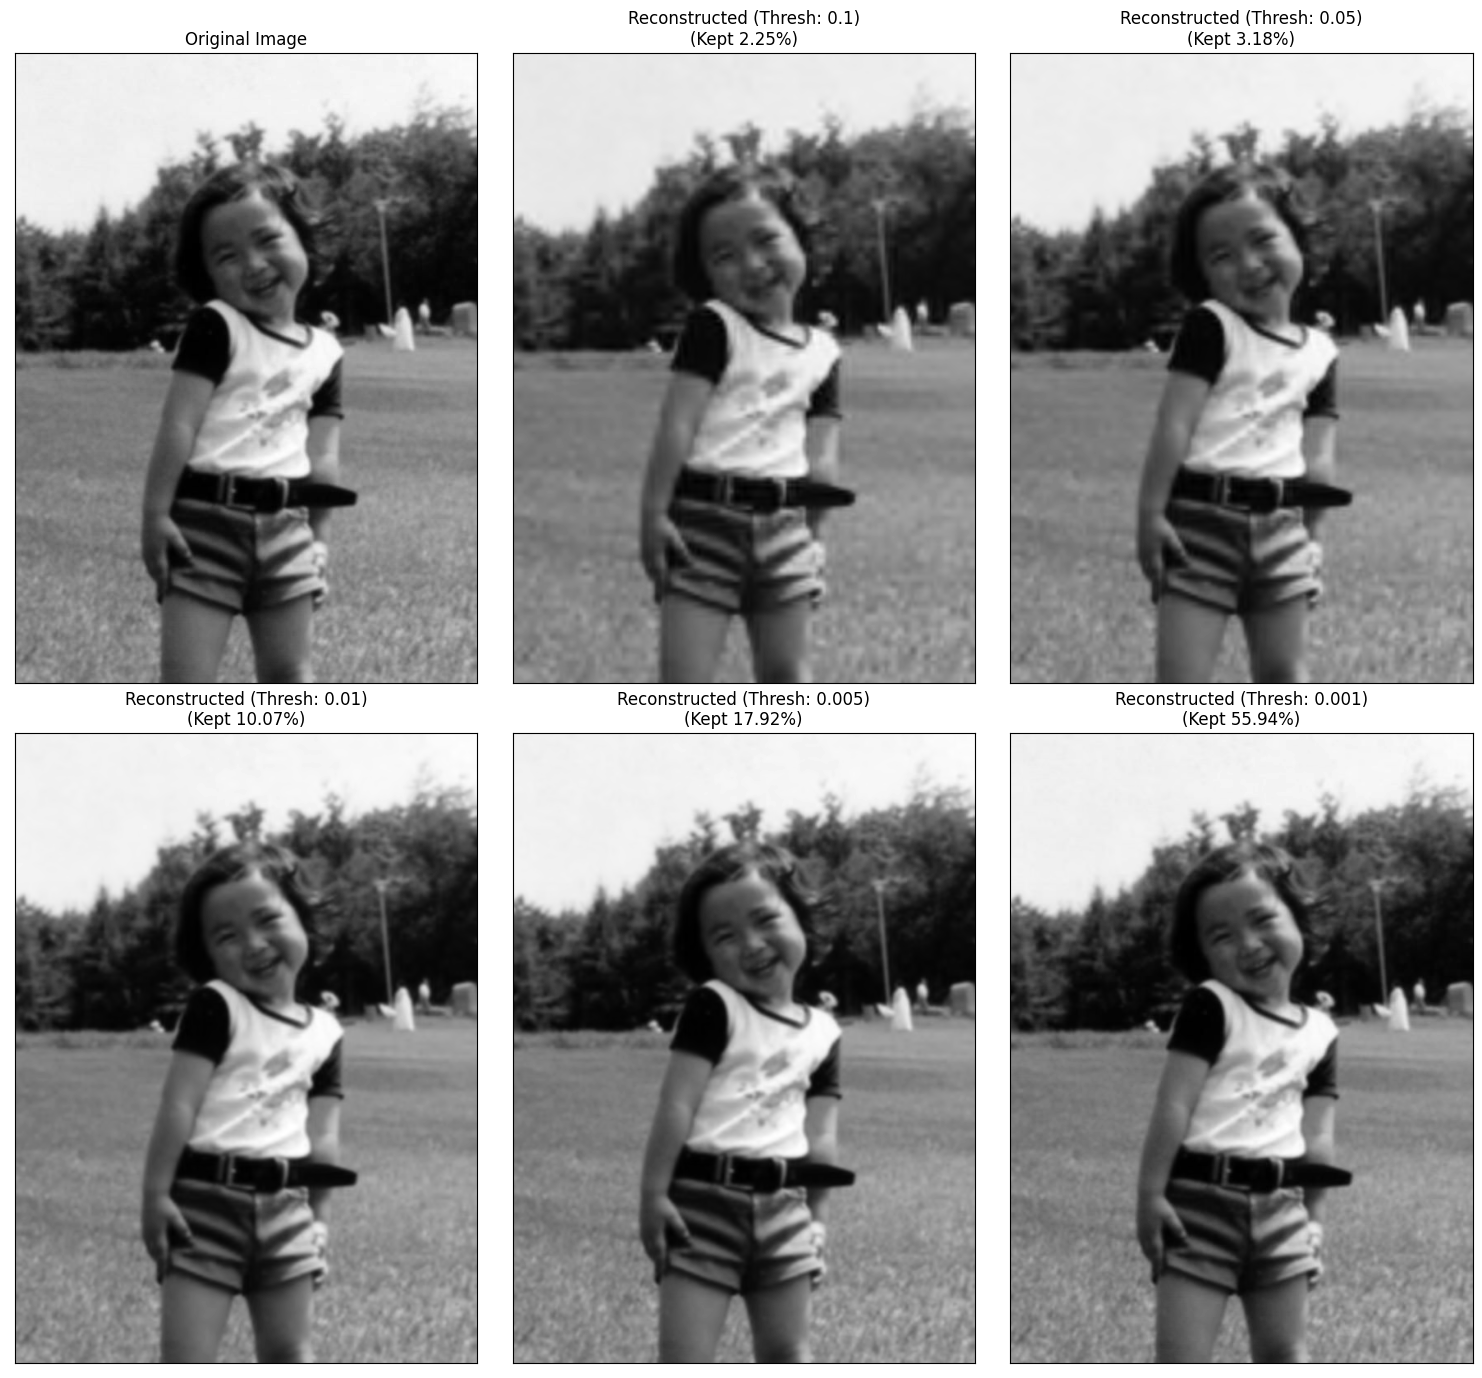

In [3]:
# Try different threshold levels
thresholds = [0.1, 0.05, 0.01, 0.005, 0.001]
num_images = len(thresholds) + 1
rows = 2
cols = (num_images + rows - 1) // rows

# Get image dimensions to calculate aspect ratio
H, W = image_np.shape
aspect_ratio = W / H

# Create a figure with a size adapted to the image aspect ratio
fig_width = 15
fig_height = fig_width * (rows / cols) / aspect_ratio

# Create a figure to display the results
fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))
axes = axes.flatten()

# Display the original image
axes[0].imshow(image_np, cmap='gray')
axes[0].set_title('Original Image')
axes[0].set_xticks([])
axes[0].set_yticks([])

# Display compressed and then decompressed images
for i, thresh_ratio in enumerate(thresholds):
    # 1. Compress the image to get the data package and ratio
    compressed_data, ratio = compress(image_np, wavelet='db4', threshold_ratio=thresh_ratio)
    
    # 2. Decompress the image from the package
    reconstructed_img = decompress(compressed_data)
    
    # 3. Plot the result
    ax = axes[i+1]
    ax.imshow(reconstructed_img, cmap='gray')
    ax.set_title(f'Reconstructed (Thresh: {thresh_ratio})\n(Kept {ratio:.2f}%)')
    ax.set_xticks([])
    ax.set_yticks([])

# Hide any unused subplots
for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=1.0)
plt.show()